In [99]:
#merging all the data
import os
import pandas as pd

directory = "C:/Users/Swati/OneDrive - University of Aberdeen/python/assessments/"
dataf = []

for files in os.listdir(directory):
    if files.endswith(".txt"):
        fp = os.path.join(directory, files)
        df = pd.read_csv(fp, sep='\t')
        dataf.append(df)     
data = pd.concat(dataf, ignore_index=True)


In [100]:
#differences in cell viability
data['CV_diff1']= data['CellViability.Mut.Rep1'] - data ['CellViability.WT.Rep1']
data['CV_diff2']= data['CellViability.Mut.Rep2'] - data ['CellViability.WT.Rep2']
data['CV_diff3']= data['CellViability.Mut.Rep3'] - data ['CellViability.WT.Rep3']
data ['CV_mean']= data[['CV_diff1','CV_diff2','CV_diff3']].mean(axis=1)
#the axis is 1 for columns and 0 for series and none when not wanted.

In [101]:
# differences in mRNA expressions
data['mE_diff1']= data['mRNA.Expression.Mut.Rep1'] - data ['mRNA.Expression.WT.Rep1']
data['mE_diff2']= data['mRNA.Expression.Mut.Rep2'] - data ['mRNA.Expression.WT.Rep2']
data['mE_diff3']= data['mRNA.Expression.Mut.Rep3'] - data ['mRNA.Expression.WT.Rep3']
data['mE_mean']= data[['mE_diff1','mE_diff2','mE_diff3']].mean(axis=1)

In [102]:
# differences in protein expressions
data['pro_diff1']= data['Protein.Expression.Mut.Rep1'] - data ['Protein.Expression.WT.Rep1']
data['pro_diff2']= data['Protein.Expression.Mut.Rep2'] - data ['Protein.Expression.WT.Rep2']
data['pro_diff3']= data['Protein.Expression.Mut.Rep3'] - data ['Protein.Expression.WT.Rep3']
data['pro_mean']= data[['pro_diff1','pro_diff2','pro_diff3']].mean(axis=1)

In [103]:
#to find the mutations type
def mutation(row):
    if row["WildType.Sequence"] == row['Mutant.Sequence']:
            return "no mutation"
    elif len(row['WildType.Sequence']) == len(row['Mutant.Sequence']):
            return "substitution mutation"
    elif len(row['WildType.Sequence'] ) < len(row['Mutant.Sequence']):
        return "insertion mutation"
    else:
        return "deletion mutation"

data["type_of_mutation"] = data.apply(mutation, axis=1)


In [104]:
#to get the mutation position region
def location(row):
    wildtype_seq = row["WildType.Sequence"]
    mutant_seq = row["Mutant.Sequence"]
             
    mutation_loc = [i for i in range(min(len(wildtype_seq), len(mutant_seq))) if wildtype_seq[i] != mutant_seq[i]]
    
    if any(position < 1000 for position in mutation_loc):
        return "promoter"
    elif any(position >= 1000 for position in mutation_loc):
        return "CDS" 
    else:
        return "no mutation"  

data["mutation_position"] = data.apply(location, axis=1)


In [105]:
#to get the top 5 genes via cell viability
def CV(row):
    if row["CV_mean"] > 0:
        return "Increase"
    elif row["CV_mean"] < 0:
        return "Decrease"
    else:
        return "No Effect"

data["CV_diff_effect"] = data.apply(CV, axis=1)
sorted_genes = data.sort_values(by="CV_diff_effect", ascending=False)
top_genes = sorted_genes.head(5)
print(top_genes[["Gene","type_of_mutation","CV_diff_effect","mutation_position","CV_mean"]])

#the same can be done using the mE_mean and pro_mean values.

       Gene       type_of_mutation CV_diff_effect mutation_position   CV_mean
0       Ah3  substitution mutation       Increase          promoter  0.059187
17   Euk4r4     insertion mutation       Increase          promoter  0.135741
45     Thxr  substitution mutation       Increase          promoter  0.008113
44     Ren8      deletion mutation       Increase          promoter  0.014656
41  Pear9a7     insertion mutation       Increase          promoter  0.004762


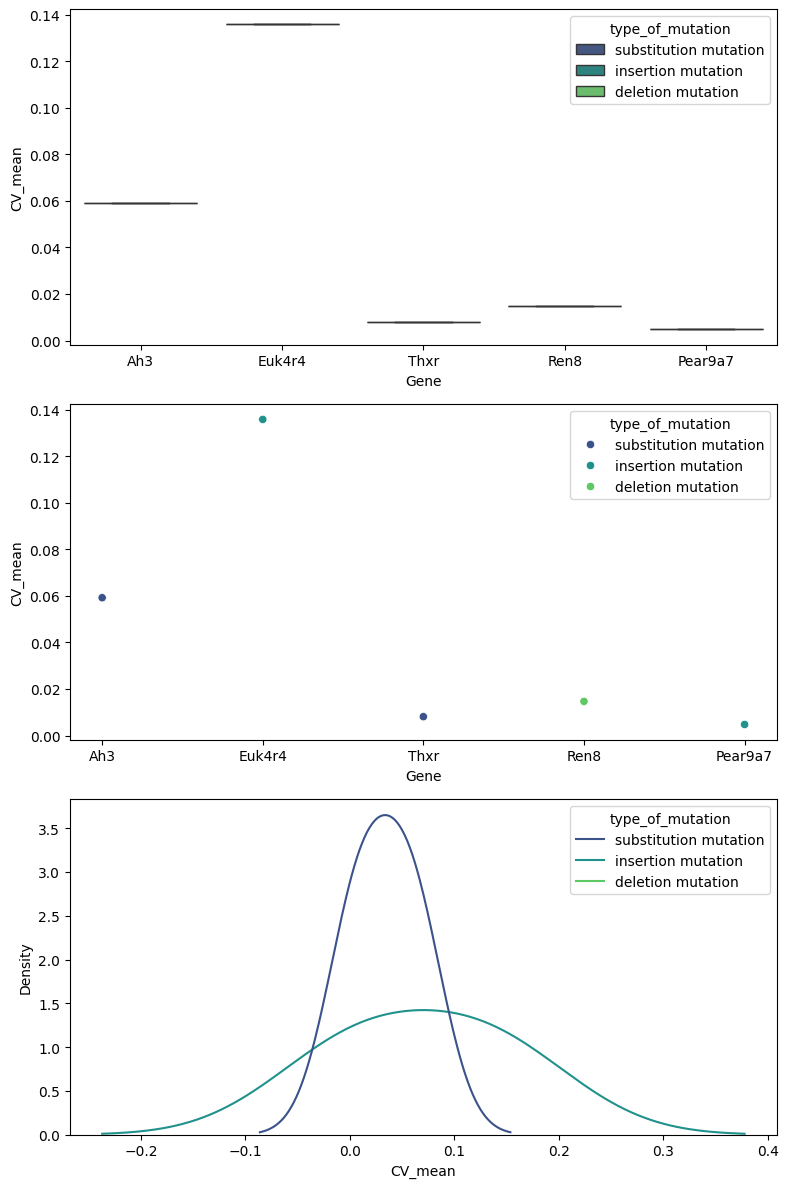

In [106]:
#making the visuals
import matplotlib.pyplot as plt
import seaborn as sbn

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Boxplot
sbn.boxplot(x="Gene", y="CV_mean", hue= "type_of_mutation", data=top_genes, palette="viridis", ax=axes[0])
axes[0].set_ylabel('CV_mean')

# Scatter plot
sbn.scatterplot(x="Gene", y="CV_mean", hue= "type_of_mutation", data=top_genes, palette="viridis", ax=axes[1])
axes[1].set_xlabel("Gene")
axes[1].set_ylabel("CV_mean")

#Kernel Density Plot
sbn.kdeplot(data=top_genes, x="CV_mean", hue="type_of_mutation", ax=axes[2], palette="viridis",warn_singular=False)
axes[2].set_xlabel("CV_mean")
axes[2].set_ylabel("Density")
plt.tight_layout()
plt.show()